In [1]:
from sklearn import preprocessing
import pandas as pd
import numpy as np
import math
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import LSTM
from keras.models import load_model

Using TensorFlow backend.


In [2]:
   def stock_history_reader(symbol):
        history = pd.read_csv("data/daily/table_{}.csv".format(symbol), delimiter=',',
                              header=None,
                              index_col='Date', parse_dates=['Date'],
                              names=['Date', 'Time', 'Open', 'High', 'Low', 'Close', 'Volume'],
                              usecols=['Date', 'Open', 'High', 'Low', 'Close', 'Volume'])
        return history

In [3]:
    def load_data(symbols):
        historical_price = {}

        for s in symbols:
            historical_price[s] = stock_history_reader(s)

        return historical_price

In [4]:
    def print_results(original, trainPredict, inverse_trainY, testPredict, inverse_testY, start=0, end=-1):
        if (end == -1):
            end = len(original)
            
        # calculate root mean squared error
        trainScore = math.sqrt(mean_squared_error(inverse_trainY, trainPredict))
        print('Train Score: %.2f RMSE' % (trainScore))
        testScore = math.sqrt(mean_squared_error(inverse_testY, testPredict))
        print('Test Score: %.2f RMSE' % (testScore))

        # shift train predictions for plotting
        trainPredictPlot = np.empty_like(original)
        trainPredictPlot[:] = np.nan
        trainPredictPlot[look_back:len(trainPredict)+look_back] = trainPredict

        # shift test predictions for plotting
        testPredictPlot = np.empty_like(original)
        testPredictPlot[:] = np.nan
        testPredictPlot[len(trainPredict)+(look_back*2)+1:len(original)-1] = testPredict

        # plot baseline and predictions
        plt.figure(figsize=(100, 50))
        plt.plot(original[start:end])
        plt.plot(trainPredictPlot[start:end])
        plt.plot(testPredictPlot[start:end])
        plt.show()

In [5]:
    def RSI(series, period):
        delta = series.diff().dropna()
        delta = delta[1:] 
        # Make the positive gains (up) and negative gains (down) Series
        up, down = delta.copy(), delta.copy()
        up[up < 0] = 0
        down[down > 0] = 0
        # Calculate the SMA
        roll_up = pd.rolling_mean(up, period)
        roll_down = pd.rolling_mean(down.abs(), period)

        # Calculate the RSI based on SMA
        RS = roll_up / roll_down
        RSI = 100.0 - (100.0 / (1.0 + RS))

        return RSI

In [6]:
    def convert_dataset(data, step_size=1):
        dataX, dataY = [], []
        for i in range(len(data) - step_size - 1):
            a = data[i:(i + step_size), :]
            dataX.append(a)
            dataY.append(data[i + step_size, -1:])
        return np.array(dataX), np.array(dataY)

    def split_data(dataset, percentage=0.67):
        train_size = int(len(dataset) * percentage)
        return dataset[0:train_size], dataset[train_size:len(dataset)]

    def create_model(trainX, trainY, epochs=100, features=1, look_back=30, firstLevel=4, secondLevel=1,\
                    loss='mse', optimizer='rmsprop'):
        # create and fit the LSTM network
        model = Sequential()
        model.add(LSTM(firstLevel, input_shape=(look_back, features), return_sequences=True))
        model.add(LSTM(secondLevel, input_shape=(look_back, features), return_sequences=False))

        model.add(Dense(16, activation="relu", kernel_initializer="uniform"))
        model.add(Dense(1, activation="linear", kernel_initializer="uniform"))
        
        model.compile(loss=loss, optimizer=optimizer, metrics=['accuracy'])
        model.fit(trainX, trainY, epochs=epochs, batch_size=1, verbose=2)

        return model

In [7]:
def prepare_multistock_data_with_rsi(look_back=15):
    print "Preparing data with look back {}".format(look_back)
    symbols = ['jpm']

    historical_data = stock_history_reader('jpm')

    # Calculate RSI for the target stock
    rsi = RSI(historical_data['Close'], 14)
    rsi = rsi.dropna()
    data = historical_data

    # Join as a new column
    data['rsi'] = rsi
    data = historical_data[15:]

    gs = stock_history_reader('gs')
    gs.columns = gs.columns.map(lambda x: 'gs_' + str(x))

    bac = stock_history_reader('bac')
    bac.columns = bac.columns.map(lambda x: 'bac_' + str(x))

    c = stock_history_reader('c')
    c.columns = c.columns.map(lambda x: 'c_' + str(x))

    data = data.join(gs)
    data = data.join(bac)
    data = data.join(c)
    data = data.dropna()
    #print data.head()

    delta = (data - data.shift(1)) / data.shift(1)
    delta = delta.dropna()

    # move Close to last column
    close = delta['Close']
    del delta['Close']
    delta = delta.join(close)

    print "No of rows loaded {}".format(len(delta))
    #print delta.head()

    # normalize the dataset
    #print delta[:3]
    scaler = MinMaxScaler(feature_range=(-1,1))
    dataset = scaler.fit_transform(delta)
    no_of_features = dataset.shape[1]
    #print dataset[:3]
    # split into train and test sets
    train, test = split_data(dataset)
    #print train[:3]
    # convert to dataset matrix
    trainX, trainY = convert_dataset(train, look_back)
    testX, testY = convert_dataset(test, look_back)
    #print trainY[:3]
    # reshape input to be [samples, time steps, features]
    trainX = np.reshape(trainX, (trainX.shape[0], trainX.shape[1], no_of_features))
    testX = np.reshape(testX, (testX.shape[0], testX.shape[1], no_of_features))
    
    return trainX, trainY, testX, testY, data, delta

In [8]:
def predict_and_print(model, data, delta, look_back=15, print_start=0, print_window=20):
    # make predictions
    trainPredict = model.predict(trainX)
    testPredict = model.predict(testX)

    # normalize the dataset
    delta_close = delta['Close']
    delta_close = np.reshape(delta_close, (delta_close.shape[0], 1))
    delta_close.astype('float32')
    scaler = MinMaxScaler(feature_range=(-1,1))
    scaler.fit_transform(delta_close)

    # invert predictions
    inverseTrainPredict = scaler.inverse_transform(trainPredict)
    inverseTrainY = scaler.inverse_transform(trainY)
    inverseTestPredict = scaler.inverse_transform(testPredict)
    inverseTestY = scaler.inverse_transform(testY)

    # Skip the look_back elements
    base = data.ix[:, 'Close']

    originalTrainY = np.empty_like(inverseTrainY)
    originalTrainPredict = np.empty_like(inverseTrainPredict)

    for x in range(0, len(inverseTrainY)):
        originalTrainY[x] = base[x + look_back] * (1 + inverseTrainY[x])
        originalTrainPredict[x] = base[x + look_back] * (1 + inverseTrainPredict[x])

    originalTestY = np.empty_like(inverseTestY)
    originalTestPredict = np.empty_like(inverseTestPredict)

    for x in range(0, len(inverseTestY)):
        originalTestY[x] = base[x + len(inverseTrainY) + look_back*2] * (1 + inverseTestY[x])
        originalTestPredict[x] = base[x + len(inverseTrainY) + look_back*2] * (1 + inverseTestPredict[x])

    print_results(base[1:].values, originalTrainPredict[:, 0], originalTrainY[:, 0], originalTestPredict[:, 0], originalTestY[:, 0], print_start, print_window)

In [69]:
filename = "lb5_e300_lvl_16_4_op_rmsprop_model.h5"
look_back = 5

trainX, trainY, testX, testY, data, delta = prepare_multistock_data_with_rsi(look_back)
model = load_model(filename)

Preparing data with look back 5
No of rows loaded 3590


/Users/jackycct/anaconda/lib/python2.7/site-packages/ipykernel/__main__.py:9: FutureWarning: pd.rolling_mean is deprecated for Series and will be removed in a future version, replace with 
	Series.rolling(window=14,center=False).mean()
/Users/jackycct/anaconda/lib/python2.7/site-packages/ipykernel/__main__.py:10: FutureWarning: pd.rolling_mean is deprecated for Series and will be removed in a future version, replace with 
	Series.rolling(window=14,center=False).mean()


Train Score: 0.40 RMSE
Test Score: 1.33 RMSE


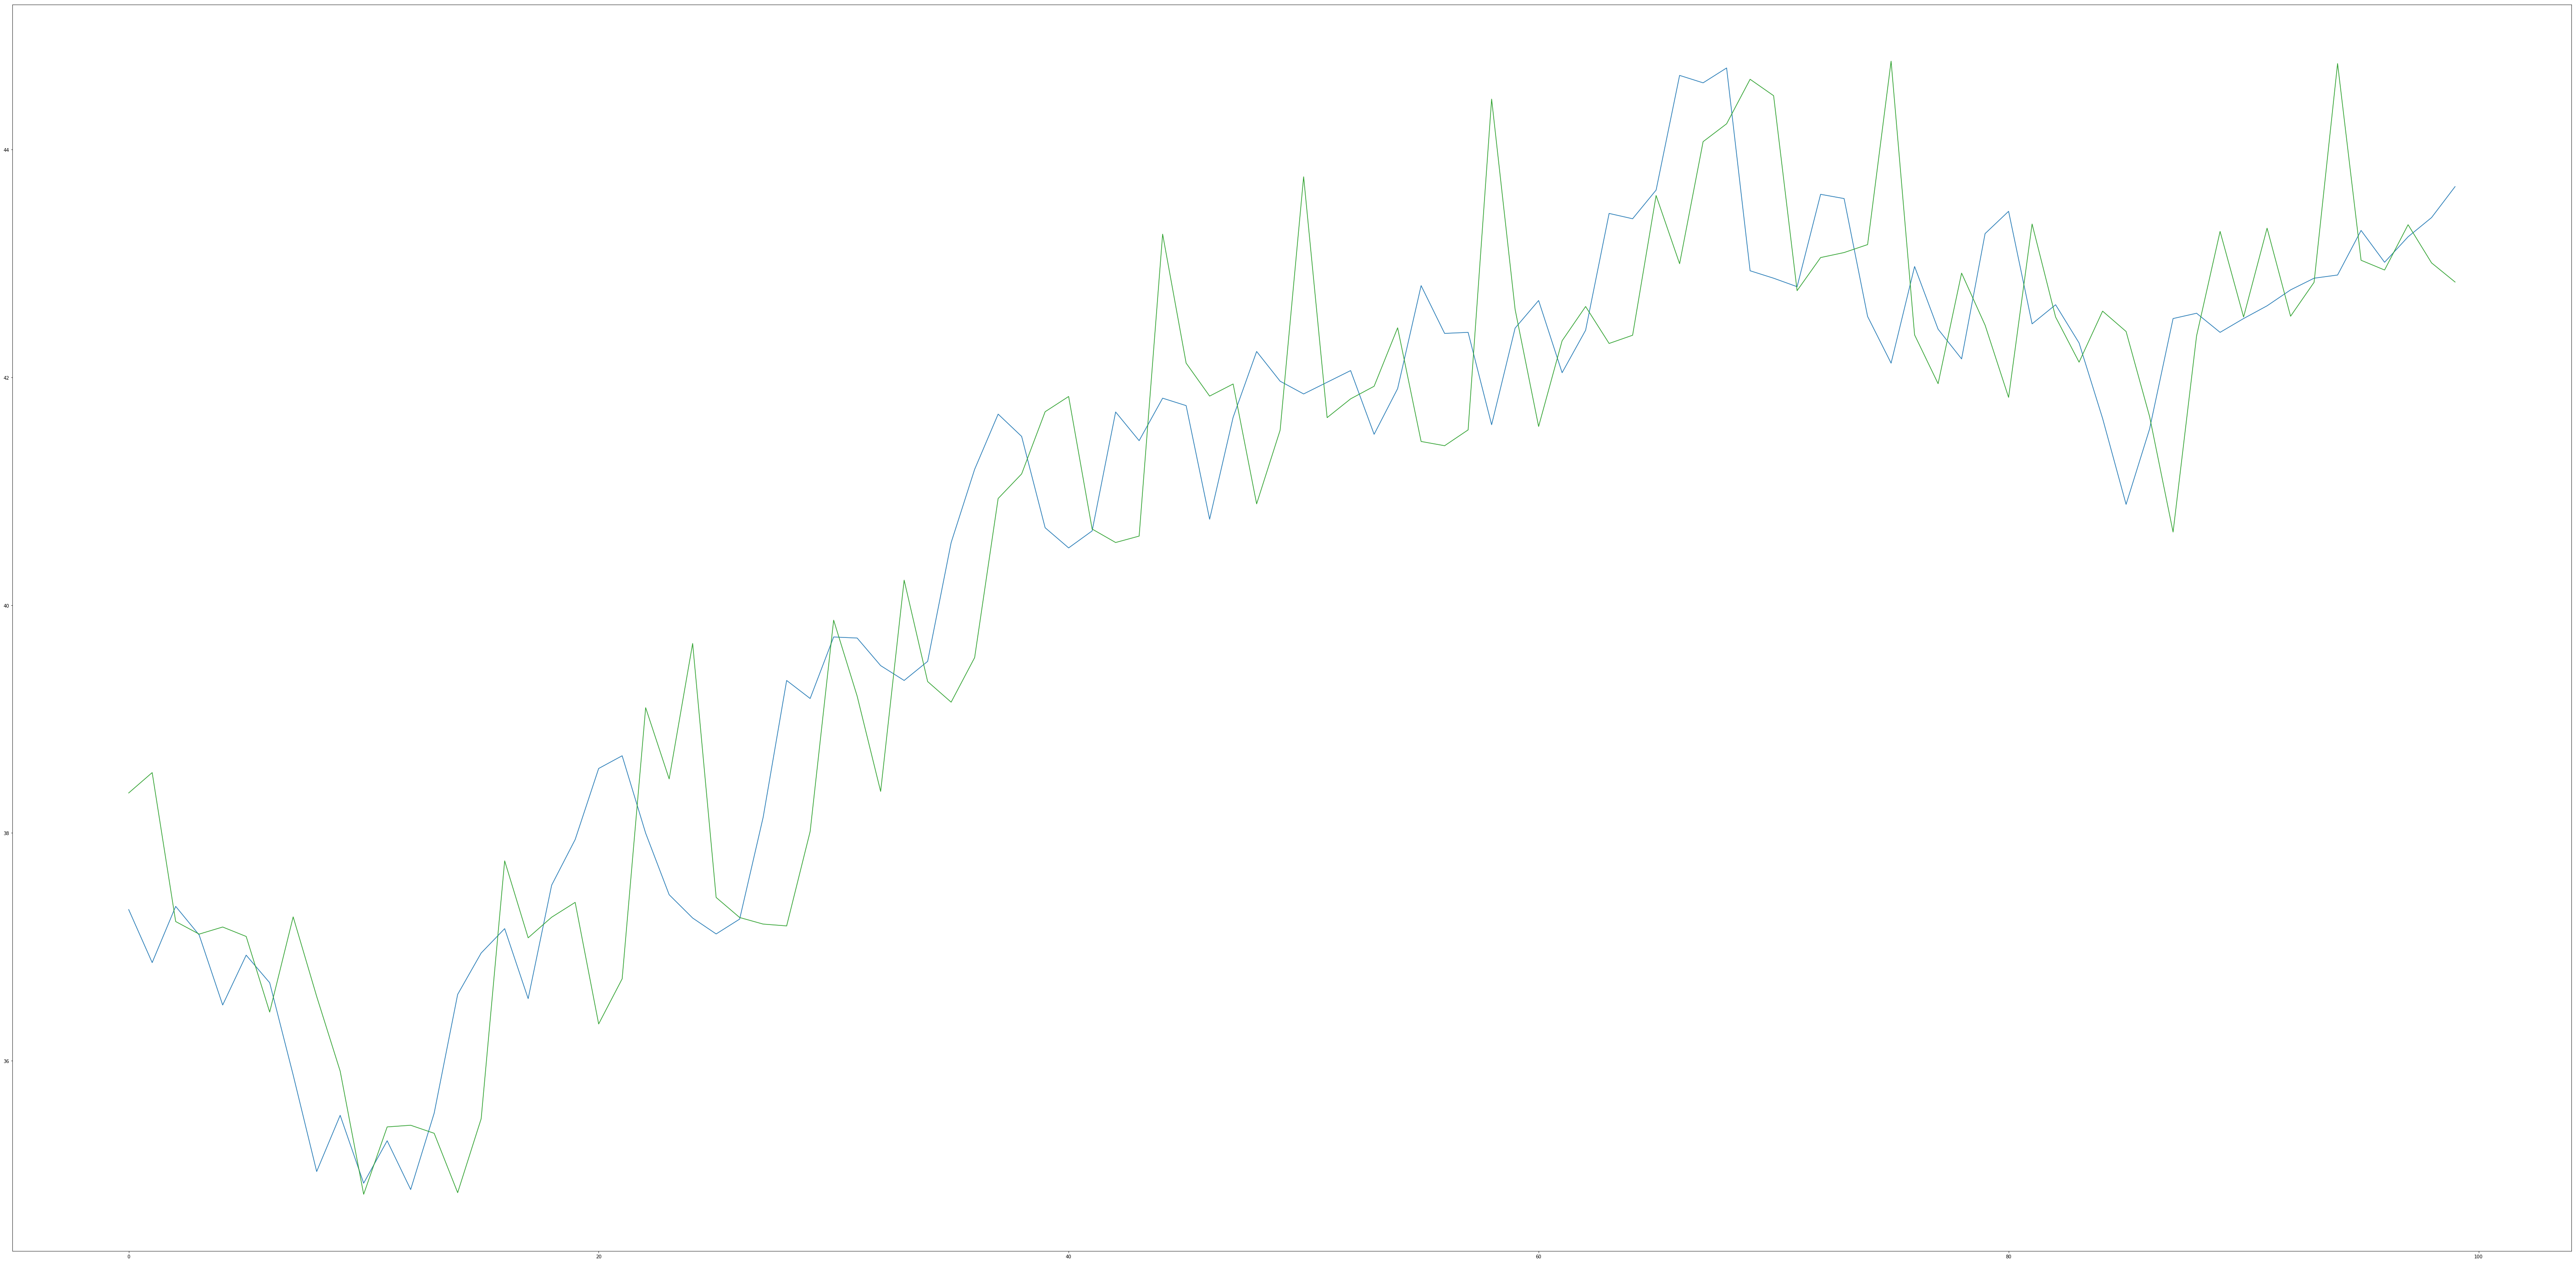

In [70]:
print_start = 2900
print_window = 3000

predict_and_print(model, data, delta, look_back, print_start, print_window)